In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [531]:
from numpy.random import normal
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [6]:
temps = normal(22, 1, 1000)

(array([ 22.,  67., 102., 221., 226., 197., 114.,  33.,  14.,   4.]),
 array([19.34965351, 19.9524671 , 20.5552807 , 21.1580943 , 21.7609079 ,
        22.36372149, 22.96653509, 23.56934869, 24.17216228, 24.77497588,
        25.37778948]),
 <a list of 10 Patch objects>)

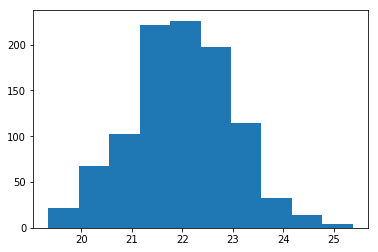

In [7]:
hist(temps)

In [16]:
from random import Random

In [17]:
rnd = Random()

In [18]:
rnd.normalvariate(0, 1)

0.6760006085671341

In [12]:
temps = [rnd.normalvariate(22, 0.5) for _ in range(1000)]

(array([  3.,  25.,  86., 162., 251., 245., 154.,  51.,  21.,   2.]),
 array([20.45294826, 20.77438649, 21.09582471, 21.41726294, 21.73870116,
        22.06013939, 22.38157761, 22.70301584, 23.02445406, 23.34589229,
        23.66733051]),
 <a list of 10 Patch objects>)

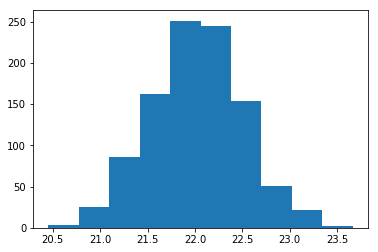

In [13]:
hist(temps)

In [89]:
P = array([[0, 1, 0],[1/6,2/3,1/6],[2/3,0,1/3]])

In [80]:
np.linalg.eig(P)[1][0]/sum(np.linalg.eig(P)[1][0])

array([0.40550952-0.j        , 0.29724524-0.21018412j,
       0.29724524+0.21018412j])

In [86]:
P = array([[0.6, 0.4, 0],[0.6,0.4,0.0],[0.5,0.5,0.0]])

In [3]:
def eiv(P):
    S, U = np.linalg.eig(P.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    return real(stationary) 

In [578]:
thermal_coefficent = lambda t: 4
temps = lambda t: [environment_temp(t) + thermal_coefficent(t)*q.T.dot(eiv(x)) for x in default_control]
omega = lambda t: [[np.abs(temps(t)[i] - temps(t)[j]) < 2 and temps(t)[i] > 17 and temps(t)[i]<26
                    for j in range(len(default_control))] for i in range(len(default_control))]

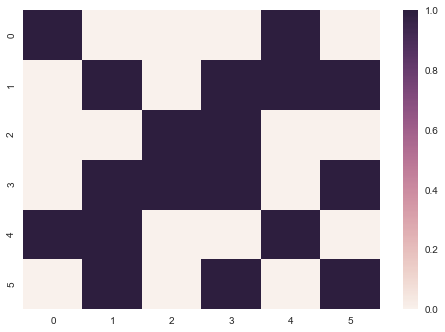

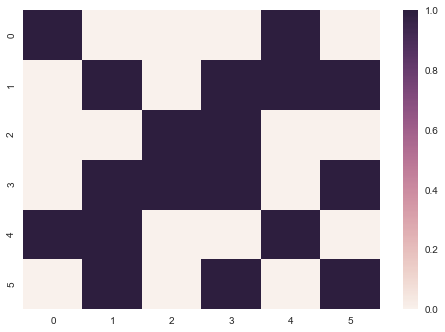

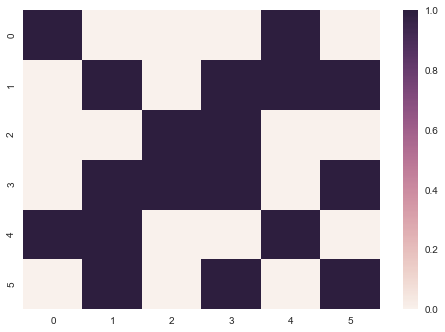

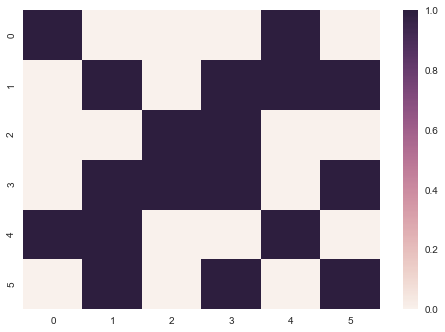

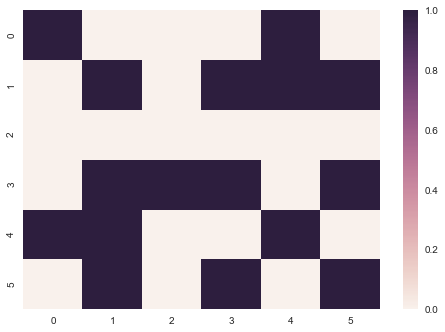

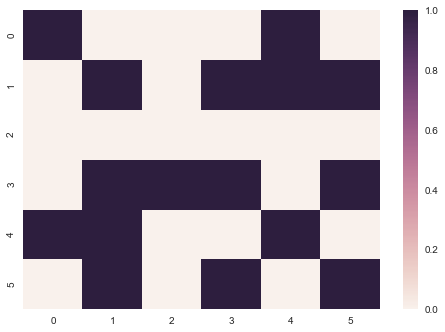

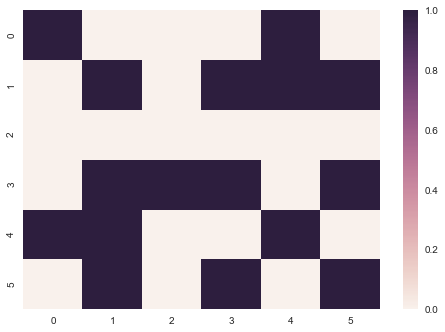

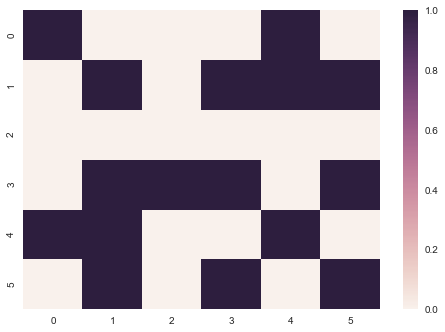

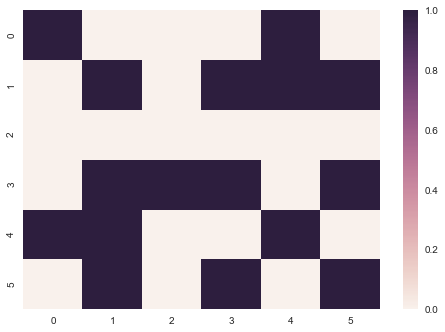

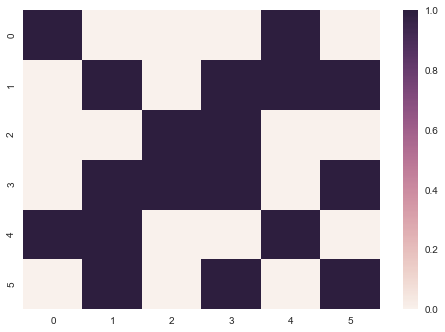

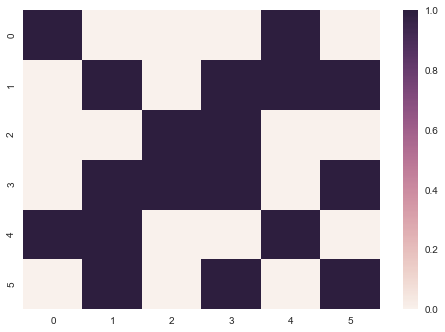

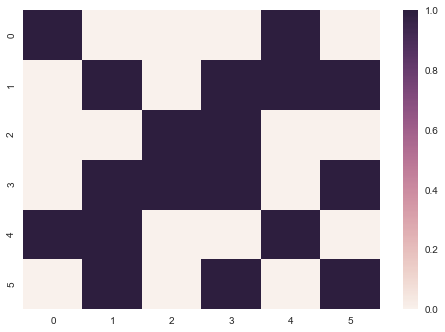

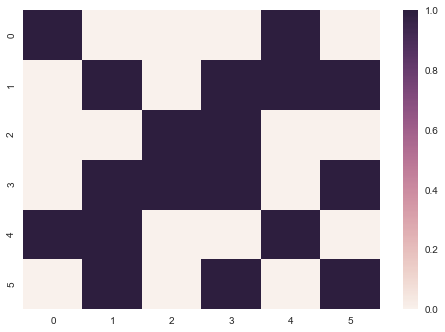

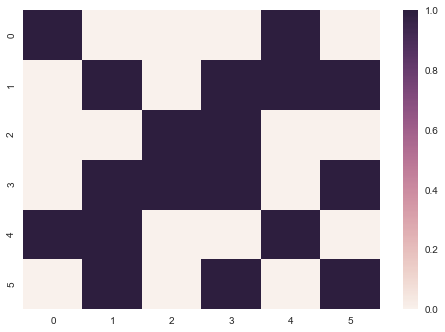

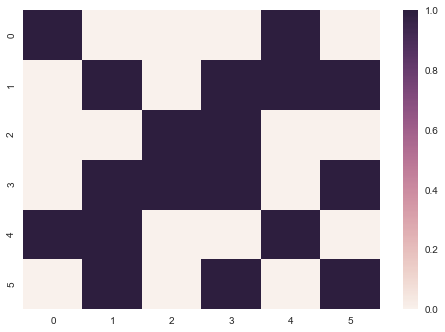

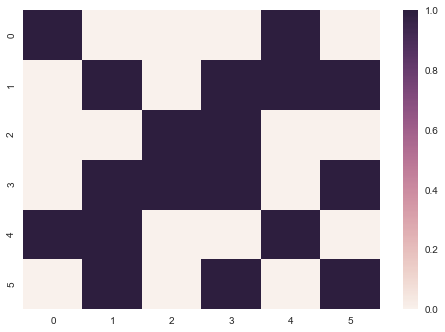

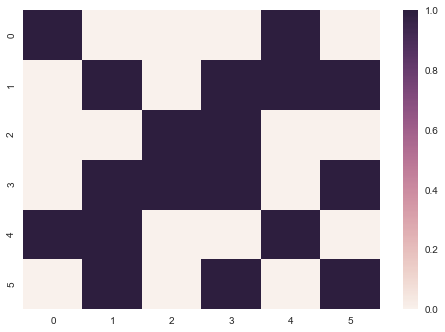

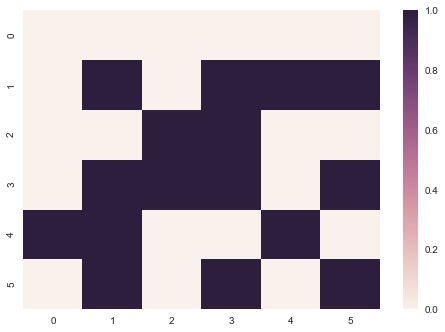

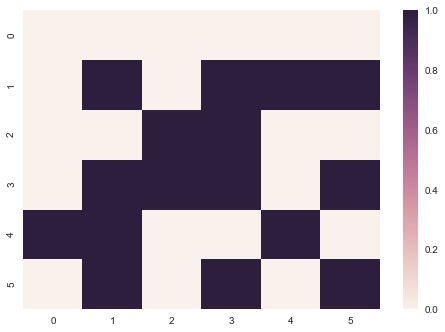

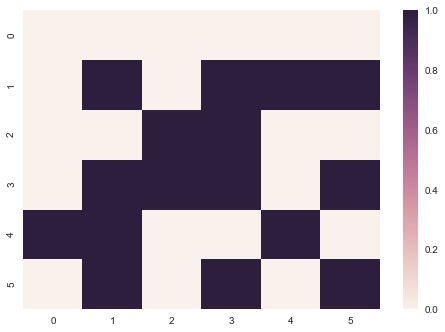

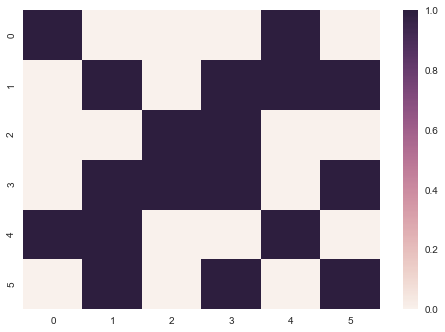

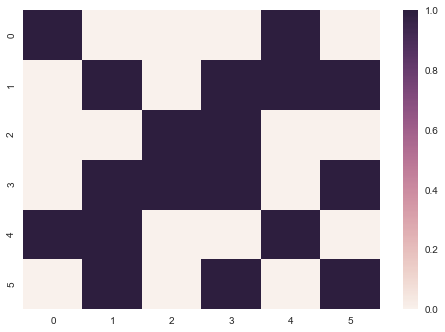

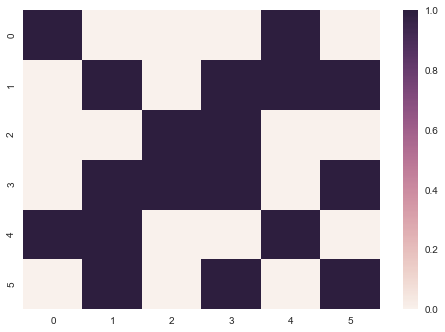

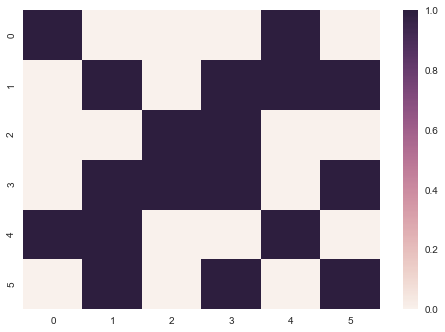

In [735]:
from src.Ensemble import RoomModel, DeviceGenerator, FastAbstractEnsemble, SystemOperator, eiv, learn_regression
from src.predefined import default_controls as controls
from src.predefined import environment_temp, generation_price, q, default_preference_profile

from sklearn.linear_model import Ridge

In [736]:
random_seed = 42
m = 6
N = 3
n = 300
tau = 3

In [737]:
model = RoomModel(environment_temp, controls, q=q, tau=tau, user_profile=default_preference_profile)

In [738]:
generator = DeviceGenerator(random_seed=random_seed, room_model=model)

In [739]:
ensemble = FastAbstractEnsemble(n, N, m, generator)

In [740]:
operator = SystemOperator(generation_price, 1600)

In [741]:
u = array([eiv(control) for control in controls])
default_control_dist = array([n/m]*m)
default_pi = 1/n*array([Nj*uj for Nj, uj in zip(default_control_dist, u)]).sum(axis=0)

approx_cons = []
datasets = [pd.DataFrame(columns=["c%d"%d for d in range(m)] + ['s']) for _ in range(24)]
train = ["c0", "c1", "c2", "c3", "c4", "c5"]
test = ["s"]

consumption_predictions = []
real_consumptions = []
operator_targets = []
classifiers = {}

pi = default_pi

In [742]:
def generate_features(pi, room_model, arm, t):
    if arm == 0:
        return [sum([q.T.dot(np.linalg.matrix_power(control.T, i).dot(pi)) for i in range(1, room_model.tau+1)])
                for control in room_model.controls]
    else:
        features = []
        for j, control in enumerate(room_model.controls):
            P = room_model.controls[arm-1] if room_model.accept(t, arm-1, j) else control
            k = sum([q.T.dot(np.linalg.matrix_power(P.T, i).dot(pi)) for i in range(1, room_model.tau+1)])
            features.append(k)
        return features

In [743]:
for t in tqdm(range(24*10)):
    time = t%24
    w_prev = classifiers.get(time)
    if w_prev is None:
        w_prev = default_control_dist
        
    target = operator.get_target()
    operator_targets.append(target)
    arm = 0
    if target == 0:
        features = generate_features(pi, model, 0, time)
    else:
        arm_features = [generate_features(pi, model, i+1, time) for i in range(m)]
        maybe_consumptions = array([w_prev.dot(feature) for feature in arm_features])
        arm = argmin(np.abs(maybe_consumptions))
        features = arm_features[arm]
        arm = arm + 1
        
    predicted_consumption = w_prev.dot(features)
    consumption_predictions.append(predicted_consumption)
    ensemble.run(arm)
    real_consumption = ensemble.log["total_consumption"][-1]
    real_consumptions.append(real_consumption)
    operator.send_consumption(real_consumption)
    datasets[time].loc[len(datasets[time])] = features + [real_consumption]
    w_new = learn_regression(np.array(datasets[time][train]), np.array(datasets[time][test]), n)    
    classifiers[time] = w_new
    pi = 1/n*array([N_j*matrix_power(P_j.T, tau).dot(pi) 
                    for N_j, P_j in zip(w_new, model.controls)]).sum(axis=0)




  0%|          | 0/240 [00:00<?, ?it/s]


  0%|          | 1/240 [00:00<00:44,  5.41it/s]


  1%|          | 2/240 [00:00<00:49,  4.82it/s]


  1%|▏         | 3/240 [00:00<00:51,  4.64it/s]


  2%|▏         | 4/240 [00:00<00:50,  4.64it/s]


  2%|▏         | 5/240 [00:01<00:51,  4.55it/s]


  2%|▎         | 6/240 [00:01<00:51,  4.51it/s]


  3%|▎         | 7/240 [00:01<00:51,  4.48it/s]


  3%|▎         | 8/240 [00:01<00:51,  4.47it/s]


  4%|▍         | 9/240 [00:02<00:52,  4.40it/s]


  4%|▍         | 10/240 [00:02<00:54,  4.23it/s]


  5%|▍         | 11/240 [00:02<00:53,  4.26it/s]


  5%|▌         | 12/240 [00:02<00:53,  4.28it/s]


  5%|▌         | 13/240 [00:03<00:53,  4.26it/s]


  6%|▌         | 14/240 [00:03<01:00,  3.72it/s]


  6%|▋         | 15/240 [00:04<01:06,  3.40it/s]


  7%|▋         | 16/240 [00:05<01:11,  3.15it/s]


  7%|▋         | 17/240 [00:05<01:18,  2.85it/s]


  8%|▊         | 18/240 [00:06<01:23,  2.66it/s]


  8%|▊         | 19/240 [00:07<01:28,  2.51it/

 57%|█████▋    | 136/240 [01:04<00:49,  2.11it/s]


 57%|█████▋    | 137/240 [01:05<00:49,  2.08it/s]


 57%|█████▊    | 138/240 [01:06<00:49,  2.06it/s]


 58%|█████▊    | 139/240 [01:07<00:49,  2.05it/s]


 58%|█████▊    | 140/240 [01:08<00:49,  2.04it/s]


 59%|█████▉    | 141/240 [01:09<00:48,  2.03it/s]


 59%|█████▉    | 142/240 [01:10<00:48,  2.02it/s]


 60%|█████▉    | 143/240 [01:11<00:48,  2.01it/s]


 60%|██████    | 144/240 [01:11<00:47,  2.00it/s]


 60%|██████    | 145/240 [01:12<00:47,  2.01it/s]


 61%|██████    | 146/240 [01:12<00:46,  2.02it/s]


 61%|██████▏   | 147/240 [01:12<00:45,  2.02it/s]


 62%|██████▏   | 148/240 [01:12<00:45,  2.03it/s]


 62%|██████▏   | 149/240 [01:13<00:44,  2.04it/s]


 62%|██████▎   | 150/240 [01:13<00:43,  2.05it/s]


 63%|██████▎   | 151/240 [01:13<00:43,  2.05it/s]


 63%|██████▎   | 152/240 [01:13<00:42,  2.06it/s]


 64%|██████▍   | 153/240 [01:13<00:42,  2.07it/s]


 64%|██████▍   | 154/240 [01:14<00:41,  2.08it/s]


 65%|██████▍

In [732]:
datasets[15]

,c0,c1,c2,c3,c4,c5,s
0,2.400000,2.400000,4.800000,2.400000,2.400000,2.400000,1422.0
1,0.600000,0.600000,4.715274,3.721167,0.600000,3.025949,1406.0
2,2.400000,2.400000,4.757359,2.400000,2.400000,2.400000,1452.0
3,2.400000,2.400000,4.765670,2.400000,2.400000,2.400000,1392.0
4,2.400001,2.400001,4.774454,2.400001,2.400001,2.400001,1434.0
5,2.400002,2.400002,4.755616,2.400002,2.400002,2.400002,1396.0
6,2.400021,2.400021,4.763611,2.400021,2.400021,2.400021,1440.0
7,2.400028,2.400028,4.767413,2.400028,2.400028,2.400028,1438.0
8,2.400068,2.400068,4.772049,2.400068,2.400068,2.400068,1466.0
9,2.400094,2.400094,4.759142,2.400094,2.400094,2.400094,1356.0


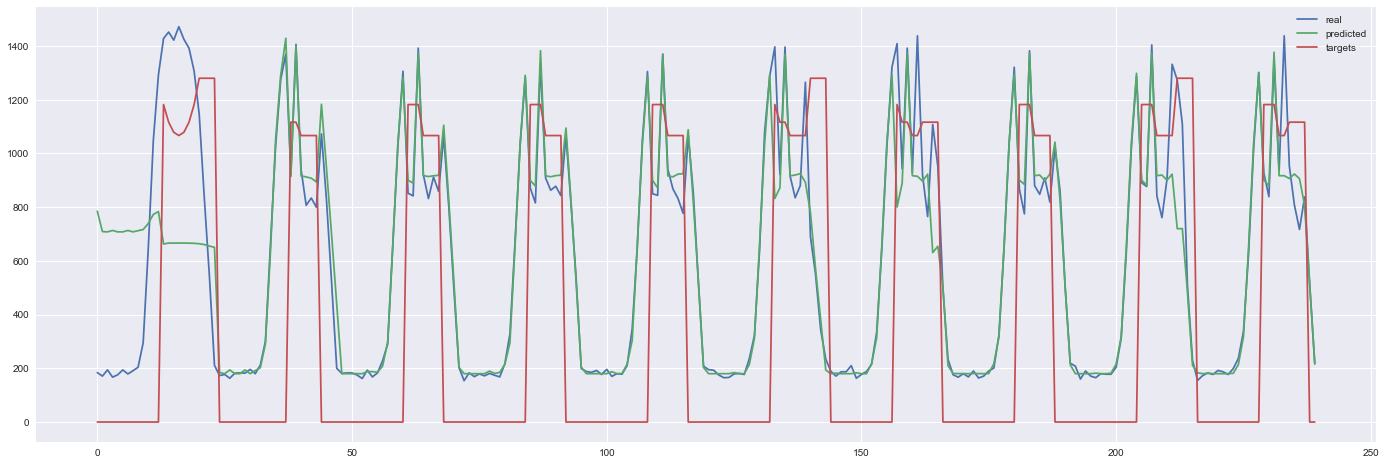

In [744]:
figure(figsize=(24, 8))
plot(real_consumptions, label="real")
plot(consumption_predictions, label="predicted")
plot(operator_targets, label="targets")
legend()
show()

In [356]:
classifiers[10].coef_

array([[37.04055897, 37.04055897, 37.04055897, 37.04055897, 37.04055897,
        37.04055897]])

In [322]:
X = array([3.422283,  3.050945,  2.764606,  2.852462,  3.169498,  2.915573]).reshape(1, -1)
Y = array([272.0])
alg = Ridge(fit_intercept=False)
alg.fit(X, Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [323]:
alg.coef_

array([16.52039906, 14.72783779, 13.3455925 , 13.76970009, 15.30012912,
       14.07435605])

In [150]:
alg.fit(datasets[0][train], datasets[0][test])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [151]:
alg.coef_

array([[0., 0., 0., 0., 0., 0.]])

In [143]:
control = controls[3]
[q.T.dot(np.linalg.matrix_power(control, i).dot(pi)) for i in range(1, tau+10)]

[0.9235564304461945,
 0.9582611548556432,
 0.9706440288713913,
 0.9721503280839896,
 0.9712317896981628,
 0.9705691701115486,
 0.9703618630003281,
 0.9703476630889107,
 0.9703685495932168,
 0.9703809098334112,
 0.9703842702754271,
 0.9703842818640087]

In [136]:
[q.T.dot(np.linalg.matrix_power(control, i).dot(pi)) for i in range(1, tau+1)]

[1.0169816272965881, 1.0169816272965884, 1.0169816272965884]

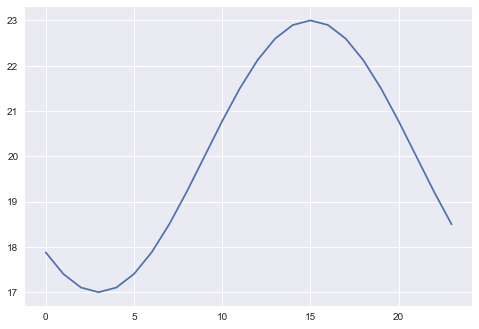

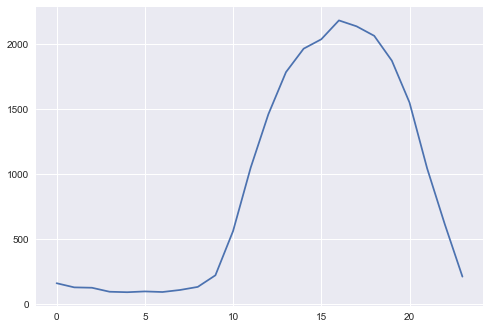

In [589]:
plot([environment_temp(t) for t in range(24)])
show()
plot([generation_price(t)*real_consumptions[t] for t in range(24)])

In [120]:
a = [[0]]*24
a[0][0] = 1
a

[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]]

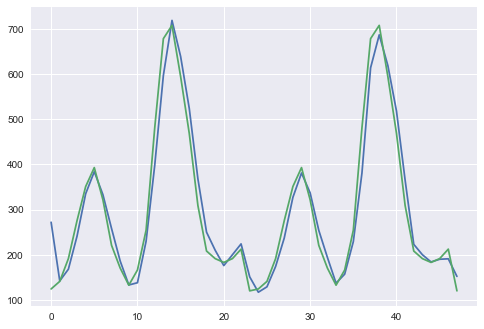

In [101]:
plot(ensemble.log["total_consumption"])
plot(approx_cons)